In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np


def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [2]:
dataset = read_epochs_dataset('../data/dataset.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [3]:
class TinyNet(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=False)
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [4]:
model = TinyNet(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam

loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(monitor='loss_val', restore_best_weights=False)
    ]
)

Epoch 0:  loss_train:  0.6919   |    binary_accuracy_train:  0.5370   |    loss_val:  0.6801   |    binary_accuracy_val:  0.5827
Epoch 1:  loss_train:  0.6693   |    binary_accuracy_train:  0.5897   |    loss_val:  0.6647   |    binary_accuracy_val:  0.6015
Epoch 2:  loss_train:  0.6484   |    binary_accuracy_train:  0.6401   |    loss_val:  0.6492   |    binary_accuracy_val:  0.6304
Epoch 3:  loss_train:  0.6272   |    binary_accuracy_train:  0.6872   |    loss_val:  0.6329   |    binary_accuracy_val:  0.6484
Epoch 4:  loss_train:  0.6049   |    binary_accuracy_train:  0.7246   |    loss_val:  0.6159   |    binary_accuracy_val:  0.6799
Epoch 5:  loss_train:  0.5816   |    binary_accuracy_train:  0.7410   |    loss_val:  0.5982   |    binary_accuracy_val:  0.6978
Epoch 6:  loss_train:  0.5576   |    binary_accuracy_train:  0.7606   |    loss_val:  0.5806   |    binary_accuracy_val:  0.7065
Epoch 7:  loss_train:  0.5335   |    binary_accuracy_train:  0.7763   |    loss_val:  0.5635   | 

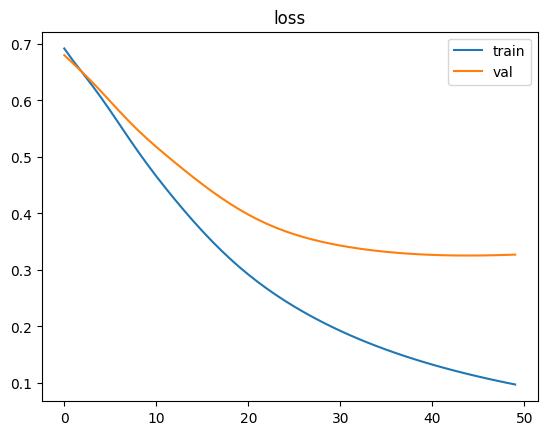

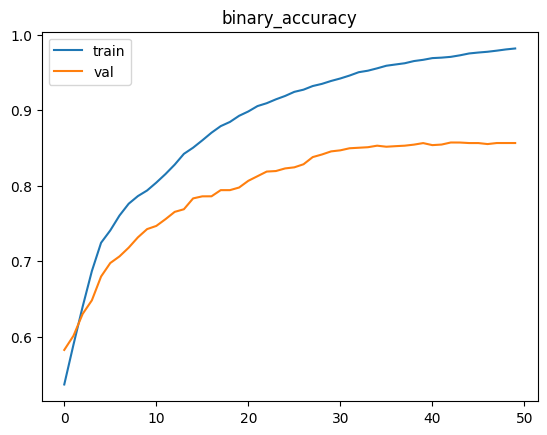

In [146]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [148]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.14779167825525458
train_binary_accuracy: 0.9529064676978372
loss: 0.27679841084913775
binary_accuracy: 0.8806818236004222


In [149]:
from copy import deepcopy
import matplotlib


class TinyNetInterpreter:
    def __init__(self, model: TinyNet, dataset: Dataset, info: mne.Info):
        self.model = model
        self.dataset = dataset
        self.info = info
        self._latent_sources = None
        self._patterns = None
        self._filters = None
        self._branchwise_loss = None

    @torch.no_grad()
    def compute_patterns(self):
        x, y = next(iter(DataLoader(self.dataset, len(self.dataset))))
        x_flatten = x.reshape(x.shape[1], x.shape[0]*x.shape[-1])
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_flatten = latent_sources.reshape(latent_sources.shape[1], latent_sources.shape[0]*latent_sources.shape[-1])
        self._latent_sources = latent_sources.numpy()
        unmixing_matrix = model.unmixing_layer.weight.numpy()[:, :, 0]
        filters = unmixing_matrix.T
        # covariance of latent_sources should aim to I, due to linear independance
        patterns = torch.cov(x_flatten)@filters@torch.cov(latent_sources_flatten)

        return patterns.numpy(), filters

    @torch.no_grad()
    def compute_branchwise_loss(self):
        loader = DataLoader(self.dataset, len(self.dataset))
        base_loss = self.model.evaluate(loader)['loss']
        n_latent = self.model.unmixing_layer.weight.shape[0]

        losses = list()
        for i in range(n_latent):
            branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :, :])
            self.model.unmixing_layer.weight[i, :, :] = 0
            losses.append(self.model.evaluate(loader)['loss'])
            self.model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original
        return base_loss - np.array(losses)

    def __validate_spatial(self):
        if self._patterns is None or self._filters is None:
            self._patterns, self._filters = self.compute_patterns()

    def __validate_branchwise_estimate(self):
        if self._branchwise_loss is None:
            self._branchwise_loss = self.compute_branchwise_loss()

    @property
    def latent_sources(self):
        # shape: n_epochs, n_latent, n_times
        self.__validate_spatial()
        return self._latent_sources
    @property
    def patterns(self):
        # shape: n_channels, n_latent
        self.__validate_spatial()
        return self._patterns
    @property
    def filters(self):
        # shape: n_channels, n_latent
        self.__validate_spatial()
        return self._filters
    @property
    def branchwise_loss(self):
        self.__validate_branchwise_estimate()
        return self._branchwise_loss

    def plot_branch(self, branch_num: int) -> matplotlib.figure.Figure:
        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)[::-1]
        patterns_sorted = self.patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax2.plot(latent_sources_sorted.mean(0)[branch_num])
        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
        )
        return fig

In [150]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

In [151]:
ti = TinyNetInterpreter(model, test, info)

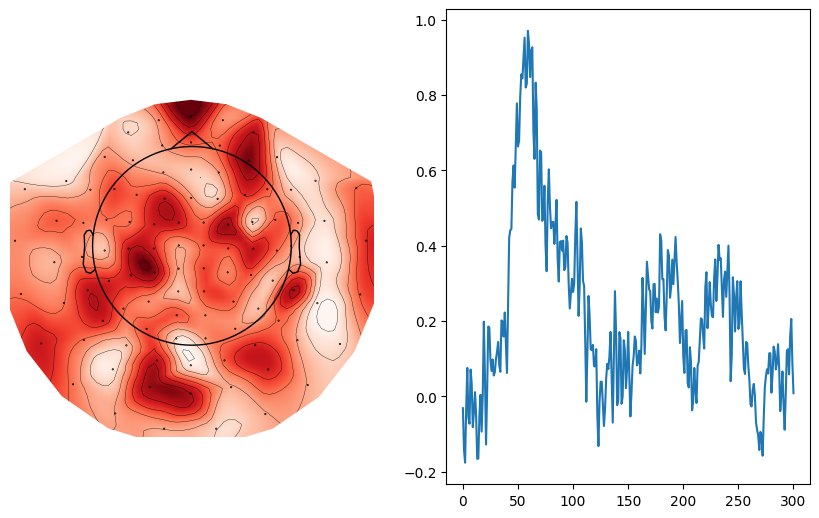

In [158]:
fig = ti.plot_branch(0)

In [3]:
class LFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor+1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [4]:
model = LFCNN(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True),
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        )
    ]
)

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7175   |    binary_accuracy_train:  0.5585   |    loss_val:  0.6985   |    binary_accuracy_val:  0.6420
Epoch 1:  loss_train:  0.6927   |    binary_accuracy_train:  0.6584   |    loss_val:  0.6779   |    binary_accuracy_val:  0.7203
Epoch 2:  loss_train:  0.6667   |    binary_accuracy_train:  0.7403   |    loss_val:  0.6552   |    binary_accuracy_val:  0.7699
Epoch 3:  loss_train:  0.6379   |    binary_accuracy_train:  0.7926   |    loss_val:  0.6293   |    binary_accuracy_val:  0.8089
Epoch 4:  loss_train:  0.6051   |    binary_accuracy_train:  0.8250   |    loss_val:  0.5998   |    binary_accuracy_val:  0.8144
Epoch 5:  loss_train:  0.5681   |    binary_accuracy_train:  0.8366   |    loss_val:  0.5673   |    binary_accuracy_val:  0.8179
Epoch 6:  loss_train:  0.5285   |    binary_accuracy_train:  0.8419   |    loss_val:  0.5341   |    binary_accuracy_val:  0.8221
Epoch 7:  loss_train:  0.4896   |    binary_accuracy_train:  0.8509   |    loss_val:  0.5037   | 

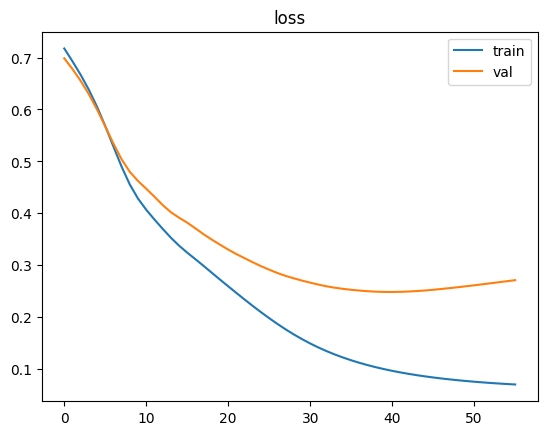

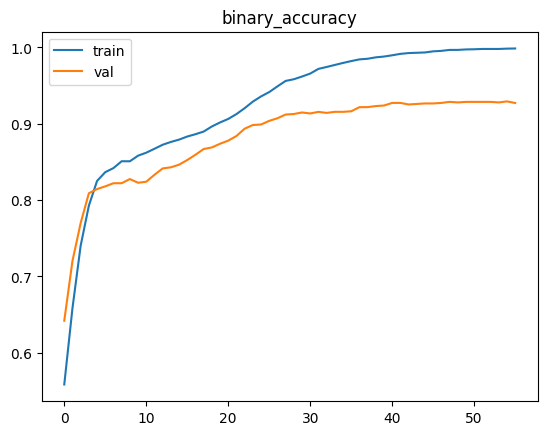

In [5]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [6]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.12689503756436435
train_binary_accuracy: 0.9776223789561879
loss: 0.26629031517288904
binary_accuracy: 0.9204545508731495


In [192]:
from copy import deepcopy
import matplotlib
import scipy as sp


class LFCNNInterpreter:
    def __init__(self, model: LFCNN, dataset: Dataset, info: mne.Info):
        self.model = model
        self.dataset = dataset
        self.info = info
        self._latent_sources = None
        self._latent_sources_filtered = None
        self._spatial_patterns = None
        self._spatial_filters = None
        self._frequency_range = None
        self._filter_inputs = None
        self._filter_responses = None
        self._filter_outputs = None
        self._filter_patterns = None
        self._branchwise_loss = None

    @torch.no_grad()
    def compute_patterns(self):
        x, y = next(iter(DataLoader(self.dataset, len(self.dataset))))
        x_flatten = x.reshape(x.shape[1], x.shape[0]*x.shape[-1])
        latent_sources = self.model.unmixing_layer(x)
        latent_sources_filtered = self.model.temp_conv(latent_sources)
        latent_sources_flatten = latent_sources_filtered.reshape(latent_sources.shape[1], latent_sources.shape[0]*latent_sources.shape[-1])
        self._latent_sources = latent_sources.numpy()
        self._latent_sources_filtered = latent_sources_filtered.numpy()
        unmixing_matrix = model.unmixing_layer.weight.numpy()[:, :, 0]
        filters = unmixing_matrix.T
        # covariance of latent_sources should aim to I, due to linear independance
        x = x.permute(1, 0, -1)
        x_flatten = x.reshape(x.shape[0], x.shape[1]*x.shape[-1])
        patterns = list()
        for comp_num in range(len(model.unmixing_layer.weight)):
            x_filt_flatten = torch.zeros_like(x_flatten)

            for ch_num in range(x.shape[0]):

                x_filt_flatten[ch_num] = torch.nn.functional.conv1d(
                    torch.unsqueeze(x_flatten[ch_num], 0),
                    torch.unsqueeze(model.temp_conv.weight[comp_num].detach(), 0),
                    padding='same'
                )
            patterns.append(torch.cov(x_filt_flatten)@model.unmixing_layer.weight[comp_num])

        patterns = torch.squeeze(torch.stack(patterns, 1))@torch.cov(latent_sources_flatten)

        return patterns.numpy(), filters

    @torch.no_grad()
    def compute_branchwise_loss(self):
        loader = DataLoader(self.dataset, len(self.dataset))
        base_loss = self.model.evaluate(loader)['loss']
        n_latent = self.model.unmixing_layer.weight.shape[0]

        losses = list()
        for i in range(n_latent):
            branch_unmixing_weights_original = deepcopy(self.model.unmixing_layer.weight[i, :, :])
            branch_unmixing_bias_original = deepcopy(self.model.unmixing_layer.bias[i])
            branch_temp_conv_bias_original = deepcopy(self.model.temp_conv.bias[i])
            self.model.unmixing_layer.weight[i, :, :] = 0
            self.model.unmixing_layer.bias[i] = 0
            self.model.temp_conv.bias[i] = 0
            losses.append(self.model.evaluate(loader)['loss'])
            self.model.unmixing_layer.weight[i, :, :] = branch_unmixing_weights_original
            self.model.unmixing_layer.bias[i] = branch_unmixing_bias_original
            self.model.temp_conv.bias[i] = branch_temp_conv_bias_original
        return base_loss - np.array(losses)

    @torch.no_grad()
    def compute_specta(self):
        filters = torch.squeeze(self.model.temp_conv.weight).detach().numpy()
        finputs, fresponces, fpatterns, foutputs = list(), list(), list(), list()
        frange = None

        for branch_num in range(self.latent_sources.shape[1]):
            lat_tc = self.latent_sources[:, branch_num, :]
            kern = filters[branch_num]
            frange, psd = sp.signal.welch(lat_tc, fs=info['sfreq'], nperseg=255)
            _, h = sp.signal.freqz(kern, 1, worN=128)
            finputs.append(psd)
            fresponces.append(np.abs(h))
            fpatterns.append(finputs[-1]*fresponces[-1])
            foutputs.append(finputs[-1]*h*np.conj(h))

        return frange, finputs, fresponces, foutputs, fpatterns

    def __validate_spatial(self):
        if self._spatial_patterns is None or self._spatial_filters is None:
            self._spatial_patterns, self._spatial_filters = self.compute_patterns()

    def __validate_spectral(self):
        if self._frequency_range is None\
            or self._filter_inputs is None\
            or self._filter_responses is None\
            or self._filter_outputs is None\
            or self._filter_patterns is None:
            self._frequency_range,\
                self._filter_inputs,\
                self._filter_responses,\
                self._filter_outputs,\
                self._filter_patterns = self.compute_specta()

    def __validate_branchwise_estimate(self):
        if self._branchwise_loss is None:
            self._branchwise_loss = self.compute_branchwise_loss()

    @property
    def latent_sources(self):
        # shape: n_epochs, n_latent, n_times
        self.__validate_spatial()
        return self._latent_sources
    @property
    def latent_sources_filtered(self):
        self.__validate_spatial()
        return self._latent_sources_filtered
    @property
    def spatial_patterns(self):
        # shape: n_channels, n_latent
        self.__validate_spatial()
        return self._spatial_patterns
    @property
    def spatial_filters(self):
        self.__validate_spatial()
        return self._spatial_filters
    @property
    def frequency_range(self):
        self.__validate_spectral()
        return self._frequency_range
    @property
    def filter_inputs(self):
        self.__validate_spectral()
        return self._filter_inputs
    @property
    def filter_responses(self):
        self.__validate_spectral()
        return self._filter_responses
    @property
    def filter_outputs(self):
        self.__validate_spectral()
        return self._filter_outputs
    @property
    def filter_patterns(self):
        self.__validate_spectral()
        return self._filter_patterns
    @property
    def branchwise_loss(self):
        self.__validate_branchwise_estimate()
        return self._branchwise_loss

    def plot_branch(
        self,
        branch_num: int,
        spec_plot_elems: list[str] = ['input', 'output', 'response']
    ) -> matplotlib.figure.Figure:
        info = deepcopy(self.info)
        info.__setstate__(dict(_unlocked=True))
        info['sfreq'] = 1.
        order = np.argsort(self.branchwise_loss)[::-1]
        patterns_sorted = self.spatial_patterns[:, order]
        latent_sources_sorted = self.latent_sources[:, order, :]
        latent_sources_filt_sorted = self.latent_sources_filtered[:, order, :]
        fake_evo = mne.evoked.EvokedArray(np.expand_dims(patterns_sorted[:, branch_num], 1), info, tmin=0)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        times = np.arange(0, latent_sources_sorted.shape[-1]/self.info['sfreq'], 1/self.info['sfreq'])
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_sorted.mean(0)[branch_num]),
            linewidth=2, alpha=0.25
        )
        ax2.plot(
            times,
            sp.stats.zscore(latent_sources_filt_sorted.mean(0)[branch_num]),
            color='tab:blue',
            linewidth=1
        )
        ax2.set_ylabel('Amplitude, zscore')
        ax2.set_xlabel('Time, s')
        ax2.legend(['Spatially filtered', 'Temporally filtered'], loc='upper right')

        spec_legend = list()
        if 'input' in spec_plot_elems:
            spec_legend.append('input')
            ax3.plot(
                self.frequency_range,
                sp.stats.zscore(self.filter_inputs[order[branch_num]].mean(0)),
                color='tab:blue',
                alpha=.25
            )
        if 'output' in spec_plot_elems:
            spec_legend.append('output')
            ax3.plot(
                self.frequency_range,
                sp.stats.zscore(self.filter_outputs[order[branch_num]].mean(0)),
                color='tab:blue',
                alpha=.75,
                linestyle='--'
            )
        if 'response' in spec_plot_elems:
            spec_legend.append('response')
            ax3.plot(
                self.frequency_range,
                sp.stats.zscore(self.filter_responses[order[branch_num]]),
                color='tab:blue',
                linewidth=.75
            )
        if 'pattern' in spec_plot_elems:
            spec_legend.append('patterns')
            ax3.plot(
                self.frequency_range,
                sp.stats.zscore(self.filter_patterns[order[branch_num]].mean(0)),
                color='tab:blue',
                alpha=.75,
                linestyle=':'
            )
        ax3.legend(spec_legend, loc='upper right')
        ax3.set_ylabel('Amplitude, zscore')
        ax3.set_xlabel('Frequency, Hz')
        ax3.set_xlim(0, 100)

        fake_evo.plot_topomap(
            times=0,
            axes=ax1,
            colorbar=False,
            scalings=1,
            time_format="",
            outlines='head',
            cmap='Blues'
        )
        fig.suptitle(f'Branch {branch_num}', y=0.95, x=0.2, fontsize=30)
        return fig

In [122]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
info = mne.io.read_raw_fif(fname_raw).resample(600).pick_types(meg='grad').info

In [193]:
interpreter = LFCNNInterpreter(model, test, info)

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


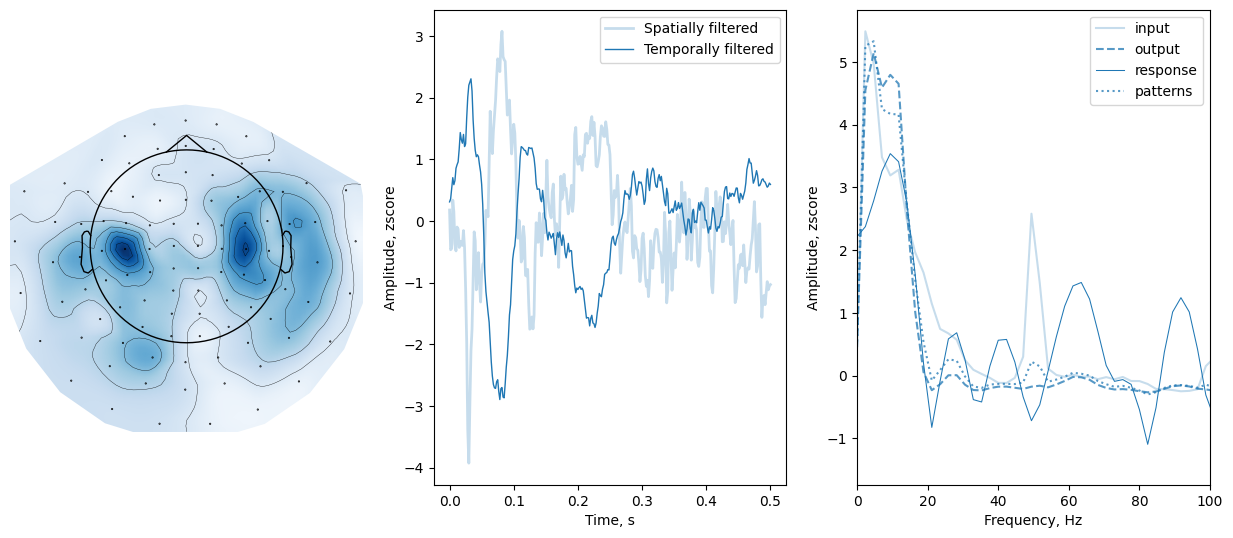

In [194]:
fig = interpreter.plot_branch(2, ['input', 'output', 'response', 'pattern'])


In [116]:
interpreter.filter_outputs[0].shape

(282, 128)

In [11]:
filters = torch.squeeze(model.temp_conv.weight).detach().numpy()

In [520]:
filters.shape

(8, 50)

In [12]:
lat_tcs = interpreter.latent_sources
lat_tcs_filt = interpreter.latent_sources_filtered

In [31]:
lat_tcs.shape

(282, 8, 301)

In [43]:
lat_tcs_filt_conv = list()

for epoch in lat_tcs:
    lat_tcs_filt_conv_epoch = list()
    for branch, kern, bias in zip(epoch, filters, model.temp_conv.bias):
        lat_tcs_filt_conv_epoch.append(
            np.convolve(branch, kern[::-1], 'same') + bias.item()
        )
    lat_tcs_filt_conv.append(lat_tcs_filt_conv_epoch)

lat_tcs_filt_conv = np.array(lat_tcs_filt_conv)

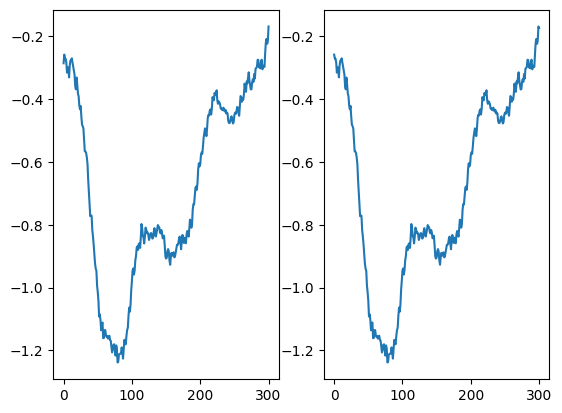

In [44]:
n_branch = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lat_tcs_filt_conv.mean(0)[n_branch])
ax2.plot(lat_tcs_filt.mean(0)[n_branch])

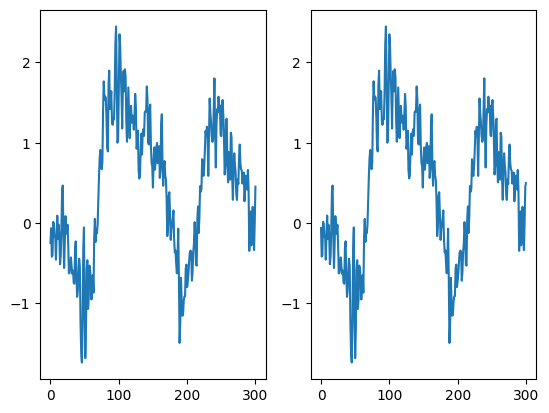

In [45]:
n_branch = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lat_tcs_filt_conv[0][n_branch])
ax2.plot(lat_tcs_filt[0][n_branch])

In [33]:
lat_tcs_filt_conv = list()

for epoch in lat_tcs:
    lat_tcs_filt_conv_epoch = list()
    for branch, kern, bias in zip(epoch, filters, model.temp_conv.bias):
        lat_tcs_filt_conv_epoch.append(
            np.convolve(branch, kern, 'same') + bias.item()
        )
    lat_tcs_filt_conv.append(lat_tcs_filt_conv_epoch)

lat_tcs_filt_conv = np.array(lat_tcs_filt_conv)

In [293]:
n_epoch = 10
n_branch = 1

lat_sample = lat_tcs[n_epoch, n_branch]
lat_sample_filt = lat_tcs_filt[n_epoch, n_branch]
kern = filters[n_branch]

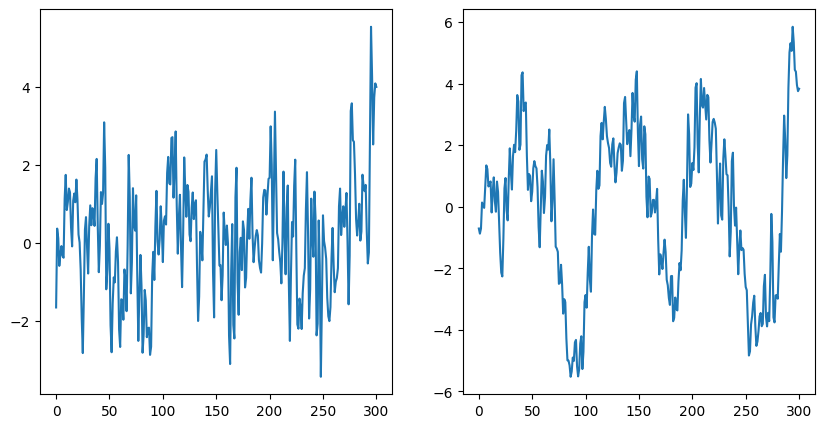

In [294]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(lat_sample)
ax2.plot(lat_sample_filt)

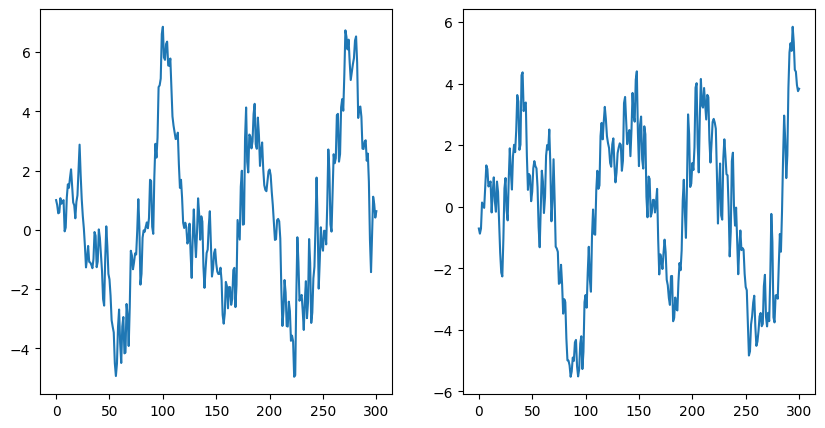

In [295]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
lat_sample_filt_conv_incorrect = np.convolve(lat_sample, kern, 'same')
ax1.plot(lat_sample_filt_conv_incorrect)
ax2.plot(lat_sample_filt)

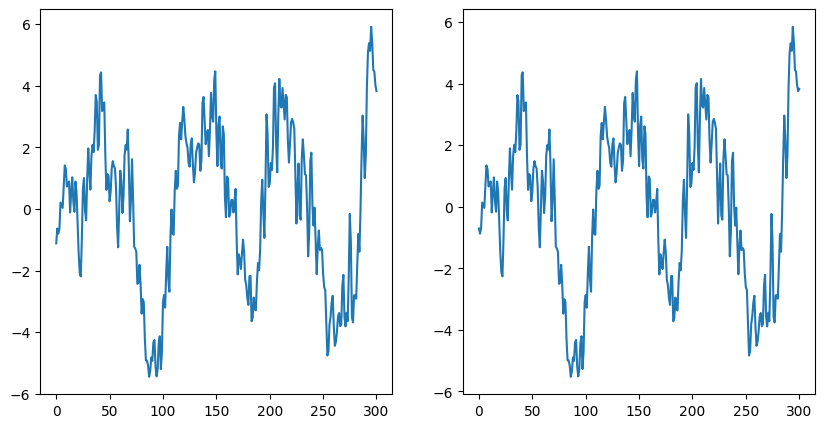

In [296]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
lat_sample_filt_conv = np.convolve(lat_sample, kern[::-1], 'same')
ax1.plot(lat_sample_filt_conv)
ax2.plot(lat_sample_filt)

In [15]:
_, psd = sl.welch(lat_sample, fs=info['sfreq'], nperseg=255)
f, psd_filt = sl.welch(lat_sample_filt, fs=info['sfreq'], nperseg=255)
w, h = sl.freqz(kern, 1, worN=128)

NameError: name 'lat_sample' is not defined

(0.0, 40.0)

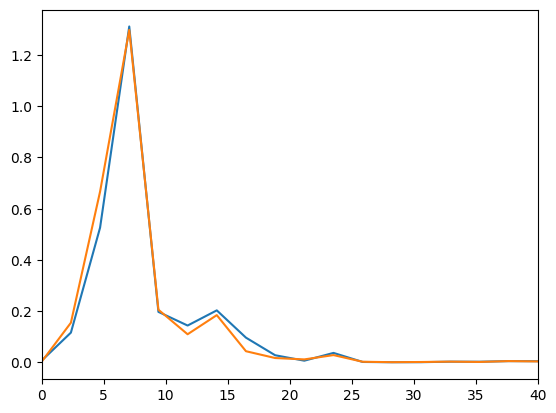

In [298]:
plt.plot(f, np.real(psd * h * np.conj(h)))
plt.plot(f, psd_filt)
plt.xlim((0, 40))

In [299]:
_, psd = sl.welch(lat_sample, fs=info['sfreq'])
f, psd_filt = sl.welch(lat_sample_filt, fs=info['sfreq'])
psd_interp = np.interp(np.arange(f[-1]), f, psd)
psd_filt_interp = np.interp(np.arange(f[-1]), f, psd_filt)
w, h = sl.freqz(kern, 1, worN=int(f[-1]))

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 50.0)

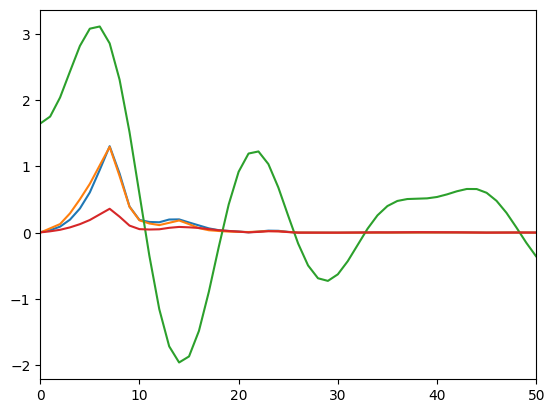

In [302]:
plt.plot(np.real(psd_interp * h * np.conj(h)))
plt.plot(psd_filt_interp)
plt.plot(h)
plt.plot(np.real(psd_interp * np.abs(h)))
plt.xlim((0, 50))

In [34]:
branch_num = 0

lat_tcs_fl = lat_tcs[:, branch_num, :].reshape(lat_tcs.shape[0]*lat_tcs.shape[-1])
lat_tcs_filt_fl = lat_tcs_filt[:, branch_num, :].reshape(lat_tcs.shape[0]*lat_tcs.shape[-1])
lat_tcs_filt_conv_fl = lat_tcs_filt_conv[:, branch_num, :].reshape(lat_tcs.shape[0]*lat_tcs.shape[-1])

In [485]:
lat_tcs_fl_conv = np.convolve(lat_tcs_fl, kern[::-1], 'same')
lat_tcs_conv = lat_tcs_fl_conv.reshape(lat_tcs.shape[0], lat_tcs.shape[-1])

In [488]:
lat_tcs_conv.shape

(282, 301)

(0.0, 40.0)

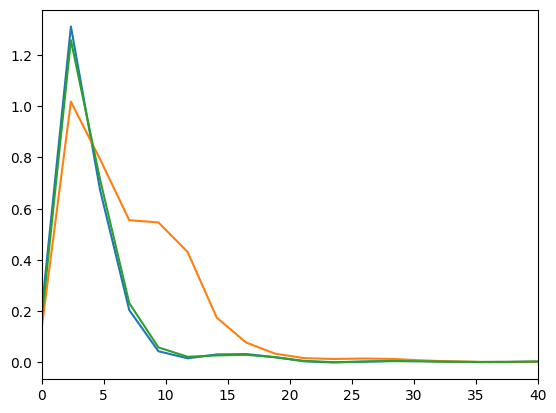

In [35]:
window = 'hamming'

_, psd = sl.welch(lat_tcs_fl, fs=info['sfreq'], nperseg=255, window=window)
f, psd_filt = sl.welch(lat_tcs_filt_fl, fs=info['sfreq'], nperseg=255, window=window)
f, psd_filt1 = sl.welch(np.convolve(lat_tcs_fl, kern[::-1], 'same'), fs=info['sfreq'], nperseg=255, window=window)
w, h = sl.freqz(kern, 1, worN=128)

plt.plot(f, np.real(psd * h * np.conj(h)))
plt.plot(f, psd_filt)
plt.plot(f, psd_filt1)
plt.xlim((0, 40))

(0.0, 50.0)

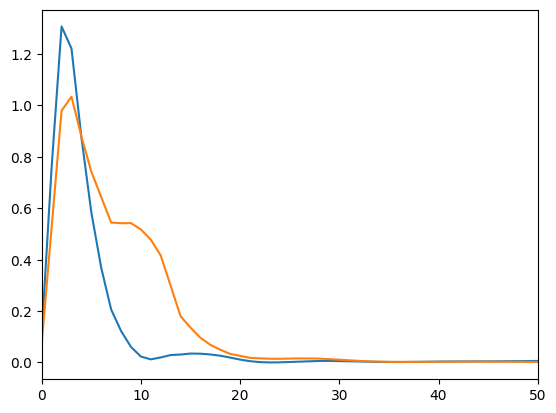

In [36]:

n = 301
window = 'taylor'
_, psd = sl.welch(lat_tcs_fl, fs=info['sfreq'], window=window)
f, psd_filt = sl.welch(lat_tcs_filt_fl, fs=info['sfreq'], window=window)
psd_interp = np.interp(np.arange(f[-1]), f, psd)
psd_filt_interp = np.interp(np.arange(f[-1]), f, psd_filt)
w, h_ = sl.freqz(kern, 1, worN=int(f[-1]))
h = sp.fft.fft(kern, 600)[:300]

plt.plot(np.real(psd_interp * h_ * np.conj(h_)))
# plt.plot(np.real(psd_interp[:-1] * h * np.conj(h)))
plt.plot(psd_filt_interp)
plt.xlim((0, 50))

In [43]:
psds = list()
psds_filt = list()
hs = list()
foutputs = list()
branch_num = 1



kern = filters[branch_num]

for lat_sample, lat_sample_filt in zip(lat_tcs[:, branch_num, :], lat_tcs_filt[:, branch_num, :]):
    kern_ = kern - kern.mean()
    # lat_sample = lat_sample - lat_sample.mean()
    # lat_sample_filt = lat_sample_filt - lat_sample_filt.mean()
    _, psd = sl.welch(lat_sample, fs=info['sfreq'], nperseg=255)
    psds.append(psd)
    f, psd_filt = sl.welch(lat_sample_filt, fs=info['sfreq'], nperseg=255)
    # lat_sample_filt_conv = np.convolve(lat_sample, kern[::-1], 'same')
    # f, psd_filt = sl.welch(lat_sample_filt_conv, fs=info['sfreq'], nperseg=255)
    psds_filt.append(psd_filt)
    w, h = sl.freqz(kern, 1, worN=128)
    # h = sp.fft.fft(kern, 128)
    hs.append(h)
    foutput = np.real(psd * h * np.conj(h))
    foutputs.append(foutput)


psds = np.array(psds)
psds_filt = np.array(psds_filt)
hs = np.array(hs)
foutputs = np.array(foutputs)

(0.0, 40.0)

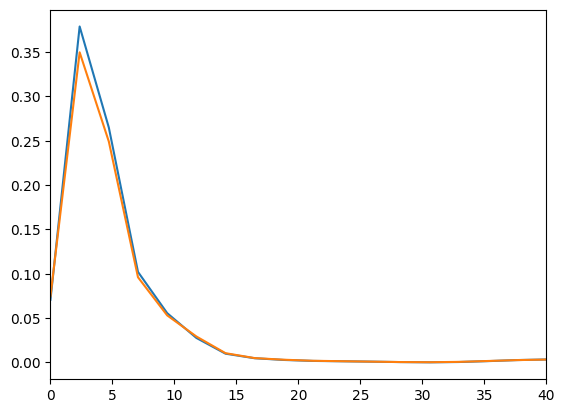

In [44]:
plt.plot(f, foutputs.mean(0))
plt.plot(f, psds_filt.mean(0))

plt.xlim((0, 40))

In [56]:
lat_tcs.shape

(282, 8, 301)

(0.0, 40.0)

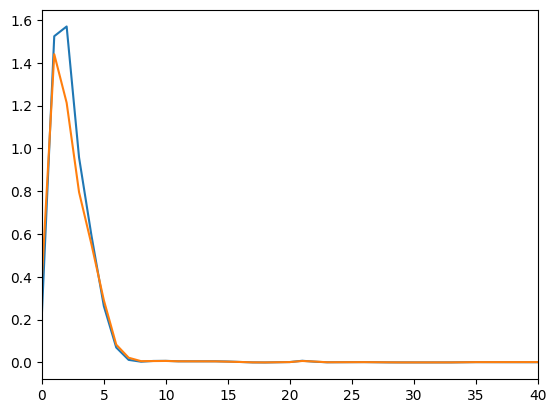

In [92]:
branch_num = 3

lat_tc, lat_tc_filt = lat_tcs[:, branch_num, :], lat_tcs_filt[:, branch_num, :]
kern = filters[branch_num]
_, psd = sl.welch(lat_tc, fs=info['sfreq'], nperseg=255)
f, psd_filt = sl.welch(lat_tc_filt, fs=info['sfreq'], nperseg=255)
w, h = sl.freqz(kern, 1, worN=128)
foutput = psd*h*np.conj(h)

plt.plot(foutput.mean(0))
plt.plot(psd_filt.mean(0))
plt.xlim((0, 40))

(0.0, 40.0)

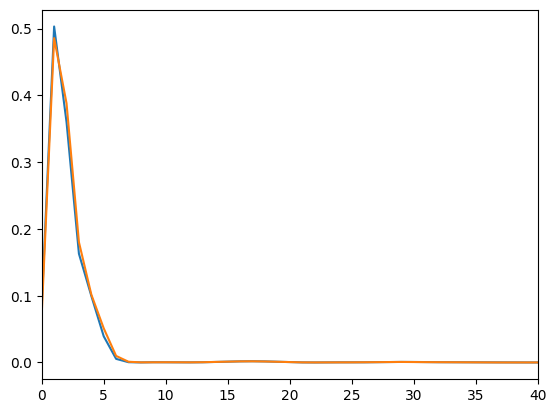

In [81]:
branch_num = 2

lat_tc, lat_tc_filt = lat_tcs[:, branch_num, :], lat_tcs_filt[:, branch_num, :]
kern = filters[branch_num]
_, psd = sl.welch(lat_tc, fs=info['sfreq'], nperseg=255)
f, psd_filt = sl.welch(lat_tc_filt, fs=info['sfreq'], nperseg=255)
w, h = sl.freqz(kern, 1, worN=128)
foutput = psd*h*np.conj(h)

plt.plot(foutput.mean(0))
plt.plot(psd_filt.mean(0))
plt.xlim((0, 40))

In [ ]:
foutputs.shape

In [14]:
import scipy.signal as sl

In [88]:
interpreter.latent_sources.shape

(282, 8, 301)

In [28]:
psds = list()
for i, branch_filter in enumerate(filters):
    lat_tcs_flatten = interpreter.latent_sources[:, i, :].reshape(interpreter.latent_sources.shape[0]*interpreter.latent_sources.shape[-1])
    psd = sl.welch(lat_tcs_flatten, fs=info['sfreq'], nperseg=info['sfreq']*2)
    w, h = (lambda w, h: (w, h))(*sl.freqz(branch_filter, 1, worN=info['sfreq']))
    frange = w / np.pi * info['sfreq'] / 2
    z = lambda x: (x - x.mean())/x.std()

    finput = psd[:-1]
    foutput = np.real(finput * h * np.conj(h))
    fresponce = np.abs(h)
    fpattern = finput * np.abs(h)

    plt.plot(frange, z(finput))
    plt.plot(frange, z(foutput))
    plt.plot(frange, z(fresponce))
    plt.plot(frange, z(fpattern))
    plt.legend(['input', 'output', 'response', 'pattern'])
    plt.show()


AttributeError: 'tuple' object has no attribute 'mean'

In [89]:
z = lambda x: (x - x.mean())/x.std()